# Spleen 3D segmentation with MONAI

## Setup environment

## Setup imports

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.2.0
Numpy version: 1.22.0
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/sun.chengkun/.conda/envs/chengkun6/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.5.0
Tensorboard version: 2.9.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1+cu113
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.3
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation

In [2]:
root_dir = "/orange/yonghui.wu/chengkun/ag"
#os.mkdir("/orange/yonghui.wu/chengkun/ag")
print(root_dir)

/orange/yonghui.wu/chengkun/ag


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [3]:
#resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
#md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
#if not os.path.exists(data_dir):
    #download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [4]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [6]:
     

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)



monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


## Check transforms in DataLoader

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


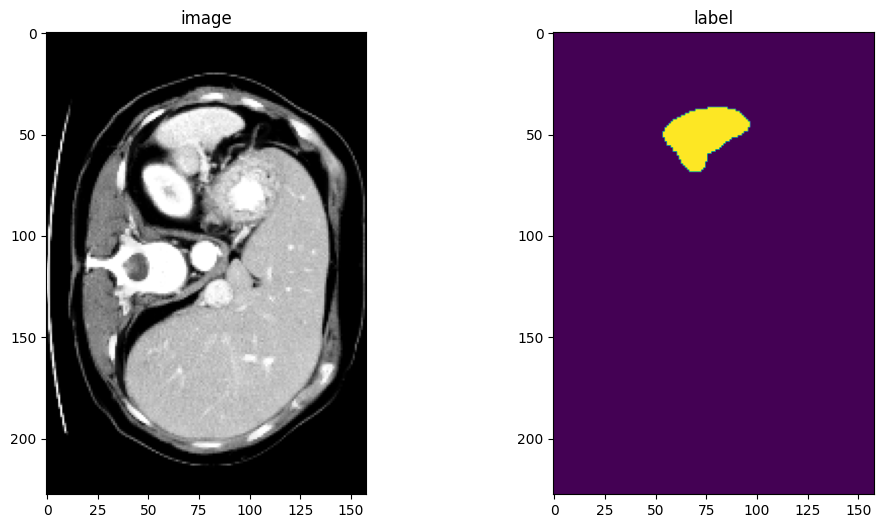

In [7]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


## Create Model, Loss, Optimizer

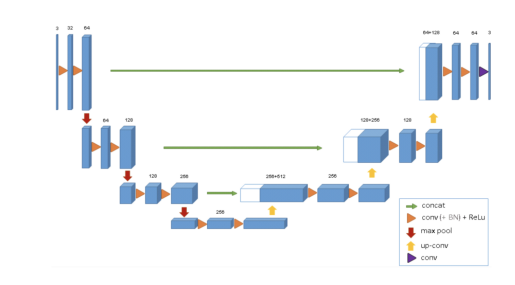

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image_path = "3dunet.png"


img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Execute a typical PyTorch training process

In [10]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/100
1/16, train_loss: 0.6642
2/16, train_loss: 0.6765
3/16, train_loss: 0.6748
4/16, train_loss: 0.6671
5/16, train_loss: 0.6557
6/16, train_loss: 0.6683
7/16, train_loss: 0.6447
8/16, train_loss: 0.6676
9/16, train_loss: 0.6559
10/16, train_loss: 0.6374
11/16, train_loss: 0.6572
12/16, train_loss: 0.6304
13/16, train_loss: 0.6524
14/16, train_loss: 0.6561
15/16, train_loss: 0.6548
16/16, train_loss: 0.6271
epoch 1 average loss: 0.6556
----------
epoch 2/100
1/16, train_loss: 0.6029
2/16, train_loss: 0.6502
3/16, train_loss: 0.6485
4/16, train_loss: 0.6376
5/16, train_loss: 0.6552
6/16, train_loss: 0.6133
7/16, train_loss: 0.6227
8/16, train_loss: 0.6309
9/16, train_loss: 0.6206
10/16, train_loss: 0.6016
11/16, train_loss: 0.6424
12/16, train_loss: 0.6310
13/16, train_loss: 0.6518
14/16, train_loss: 0.6251
15/16, train_loss: 0.6396
16/16, train_loss: 0.6087
epoch 2 average loss: 0.6301
saved new best metric model
current epoch: 2 current mean dice: 0.0342
best mean d

In [11]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9073 at epoch: 72


## Plot the loss and metric

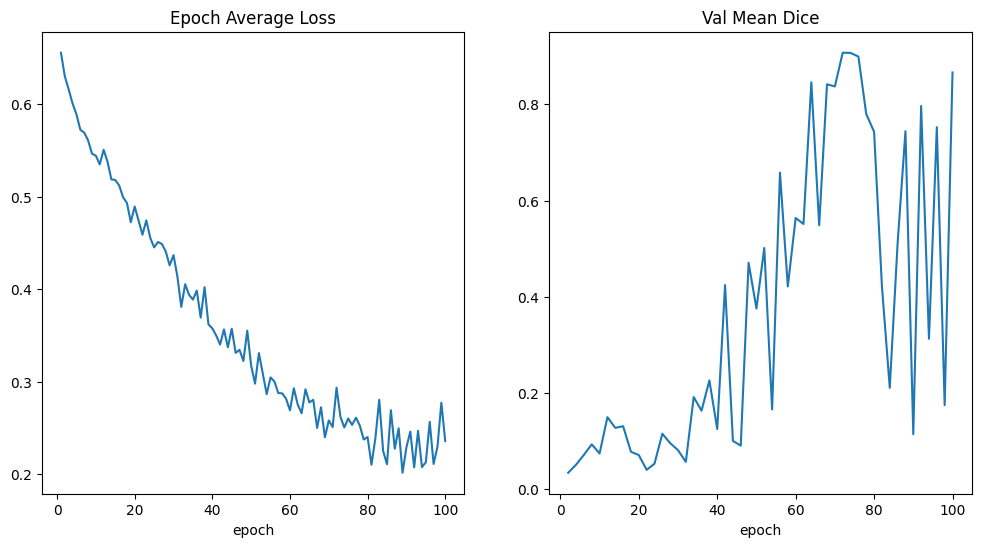

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

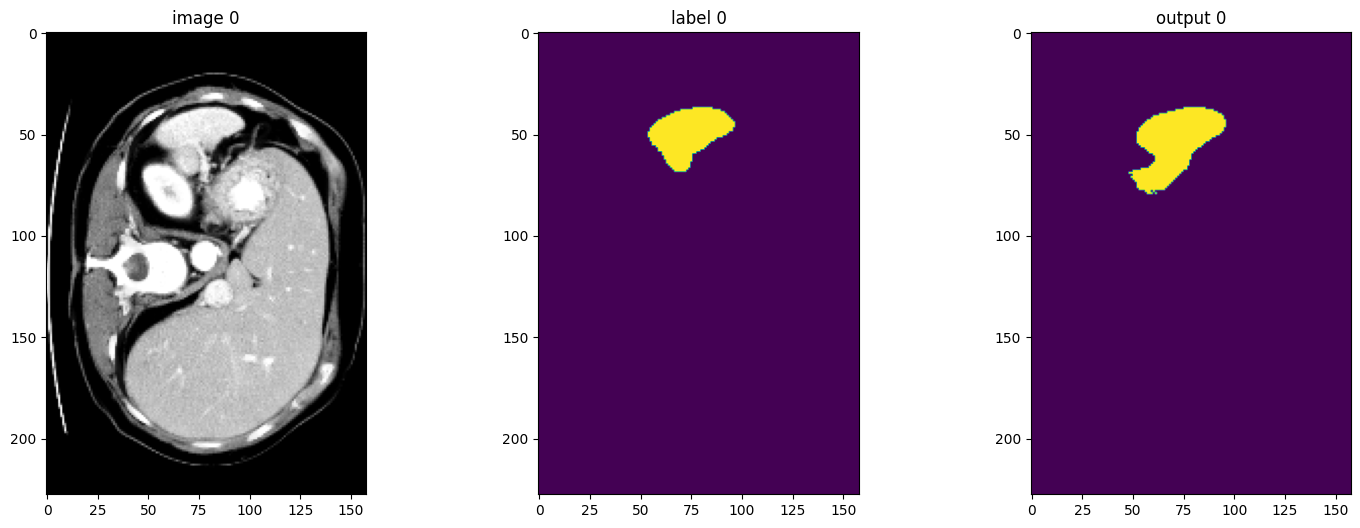

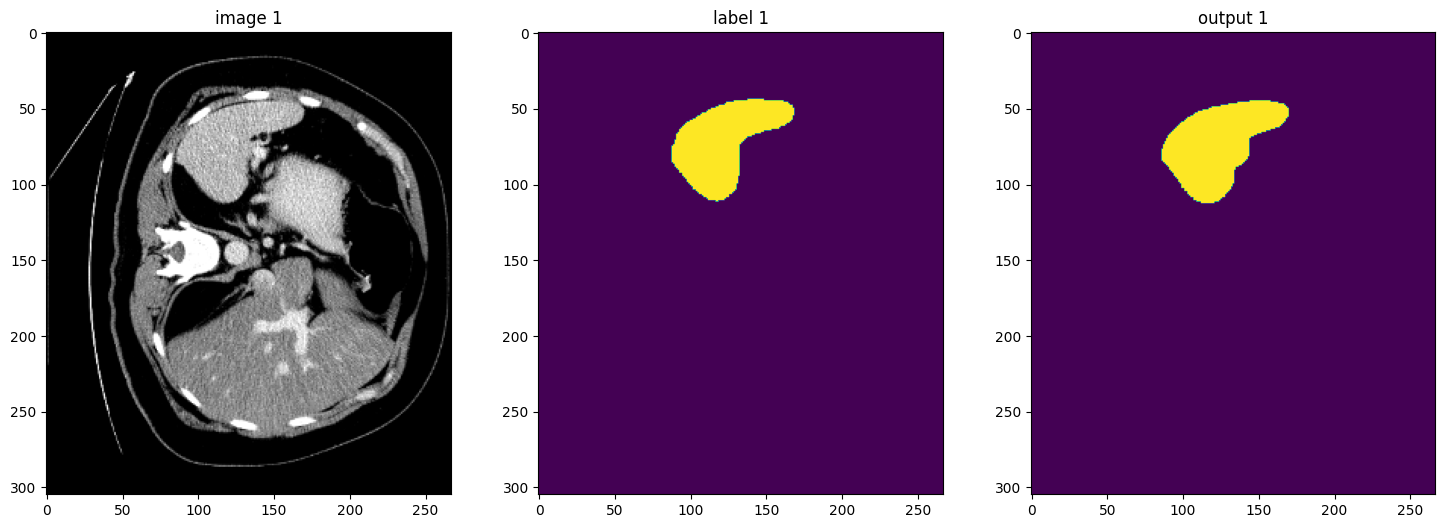

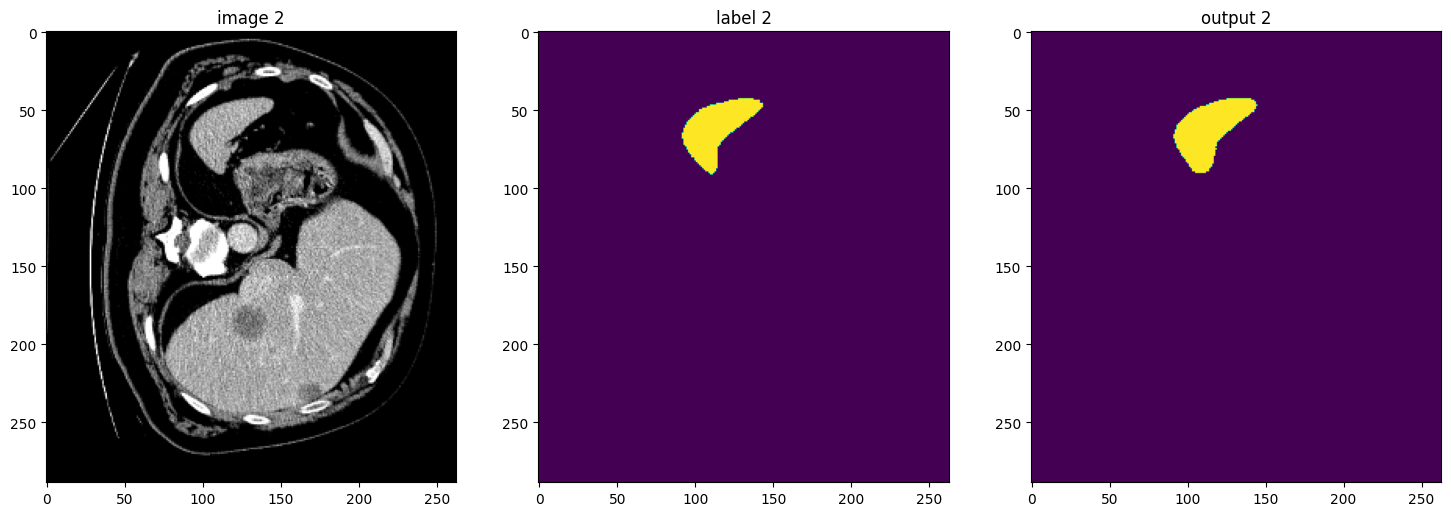

In [13]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [14]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.9177415370941162


## Inference on Test Set

In [16]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [17]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


2024-04-21 02:46:12,821 INFO image_writer.py:197 - writing: out/spleen_1/spleen_1_seg.nii.gz
torch.Size([512, 512, 34])


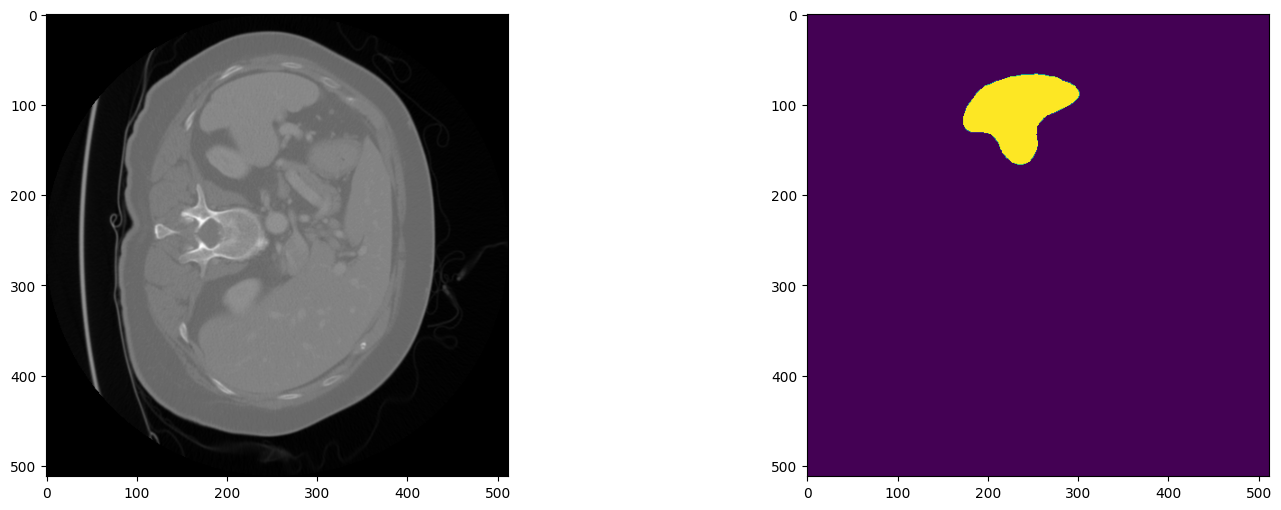

2024-04-21 02:46:15,290 INFO image_writer.py:197 - writing: out/spleen_11/spleen_11_seg.nii.gz
torch.Size([512, 512, 157])


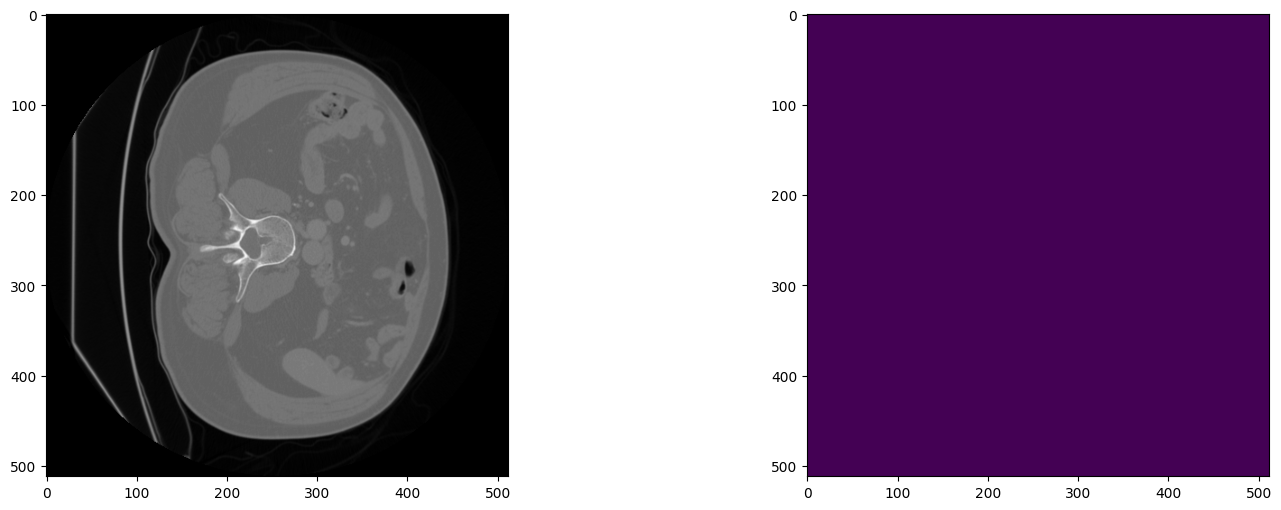

2024-04-21 02:46:21,016 INFO image_writer.py:197 - writing: out/spleen_15/spleen_15_seg.nii.gz
torch.Size([512, 512, 38])


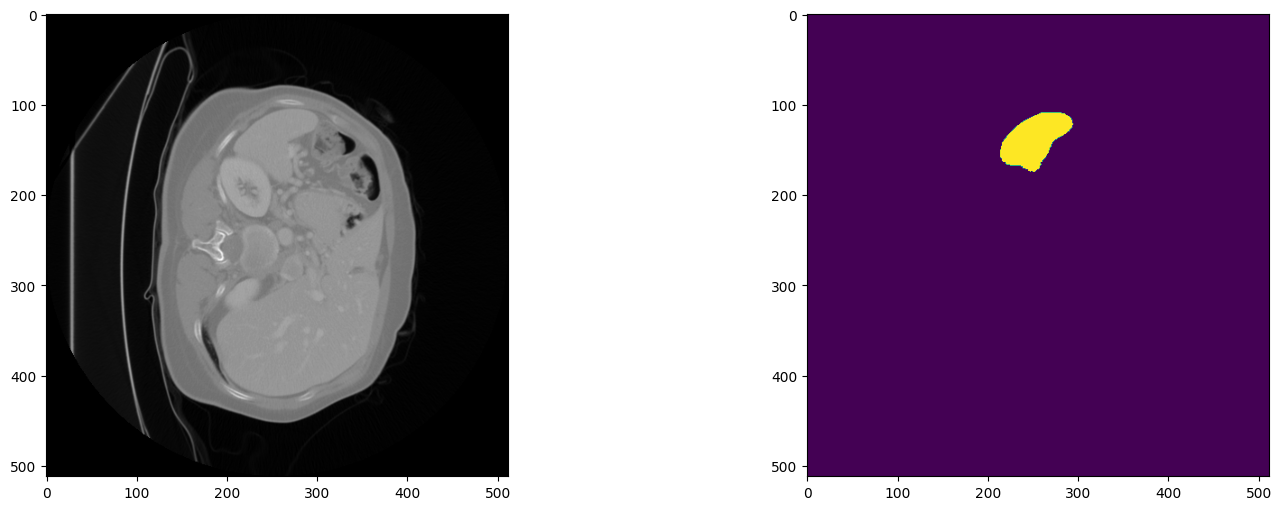

2024-04-21 02:46:22,860 INFO image_writer.py:197 - writing: out/spleen_23/spleen_23_seg.nii.gz
torch.Size([512, 512, 102])


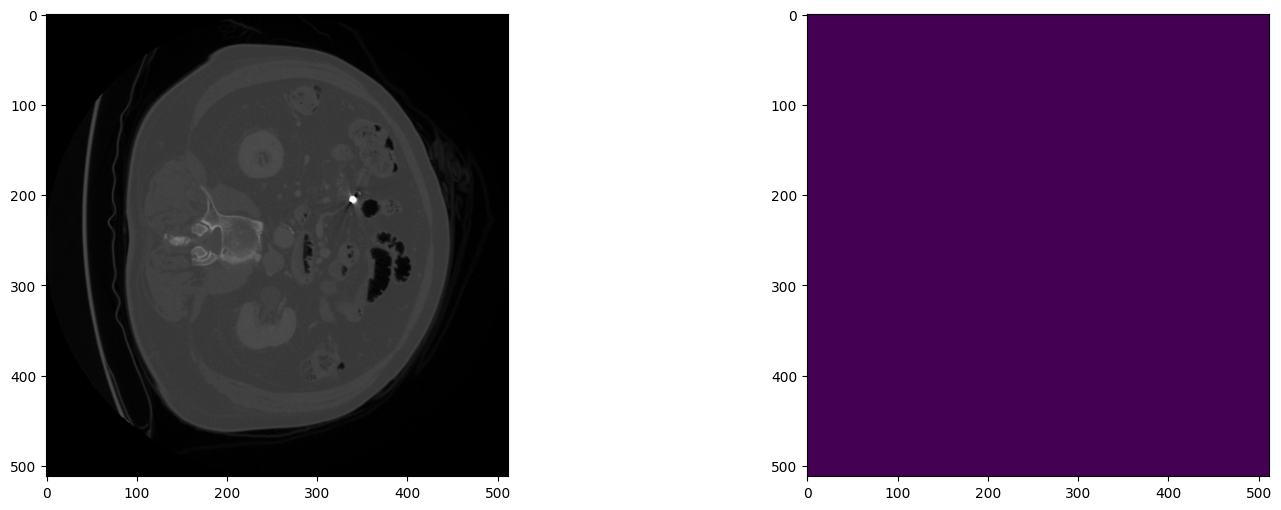

2024-04-21 02:46:26,483 INFO image_writer.py:197 - writing: out/spleen_30/spleen_30_seg.nii.gz
torch.Size([512, 512, 96])


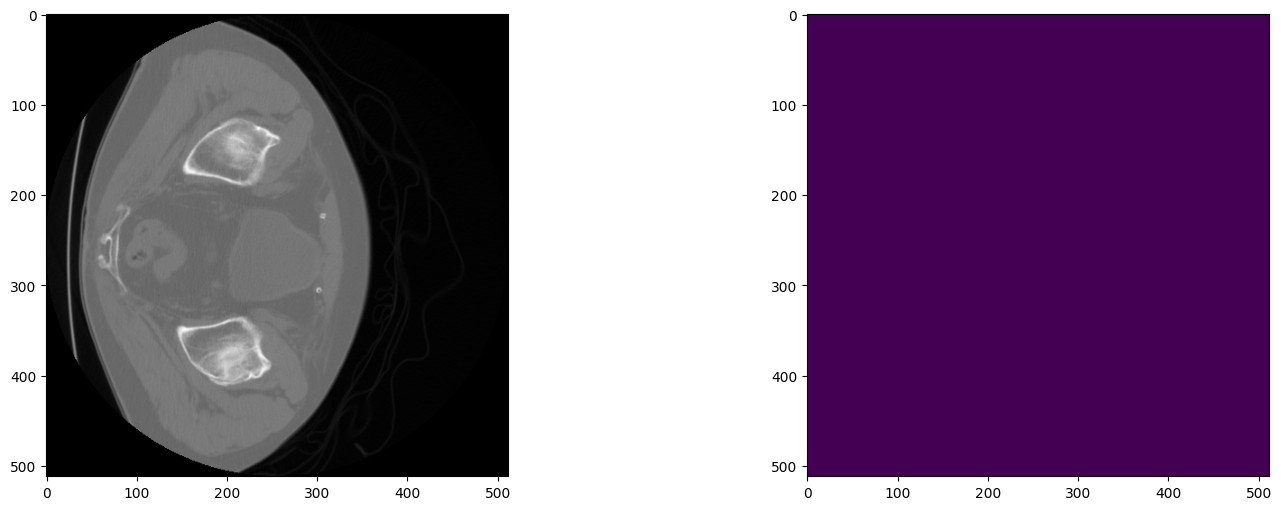

2024-04-21 02:46:29,935 INFO image_writer.py:197 - writing: out/spleen_34/spleen_34_seg.nii.gz
torch.Size([512, 512, 48])


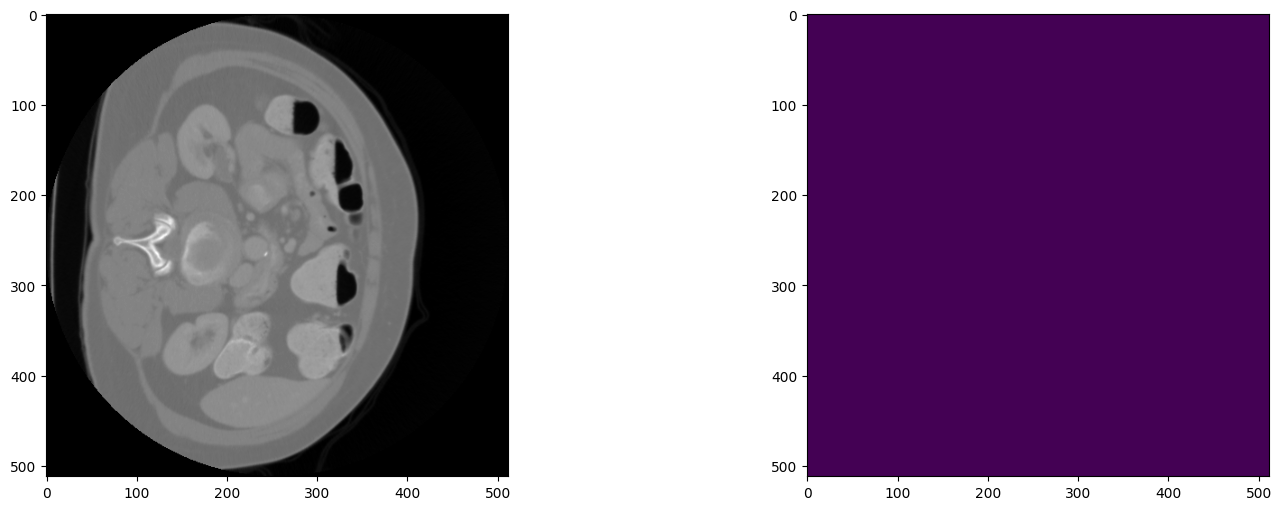

2024-04-21 02:46:31,870 INFO image_writer.py:197 - writing: out/spleen_35/spleen_35_seg.nii.gz
torch.Size([512, 512, 50])


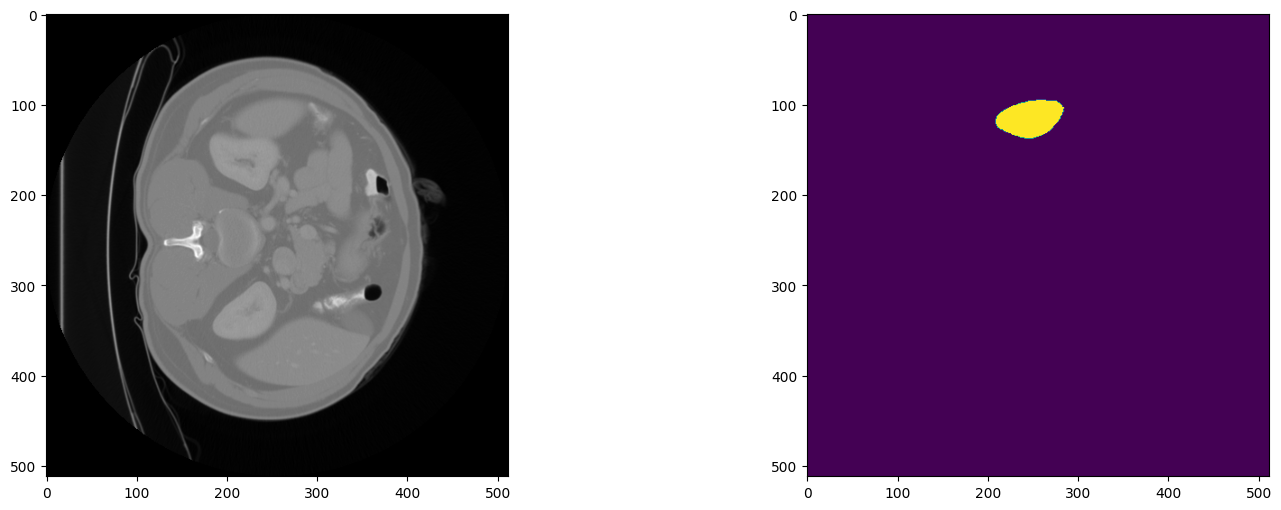

2024-04-21 02:46:34,196 INFO image_writer.py:197 - writing: out/spleen_36/spleen_36_seg.nii.gz
torch.Size([512, 512, 94])


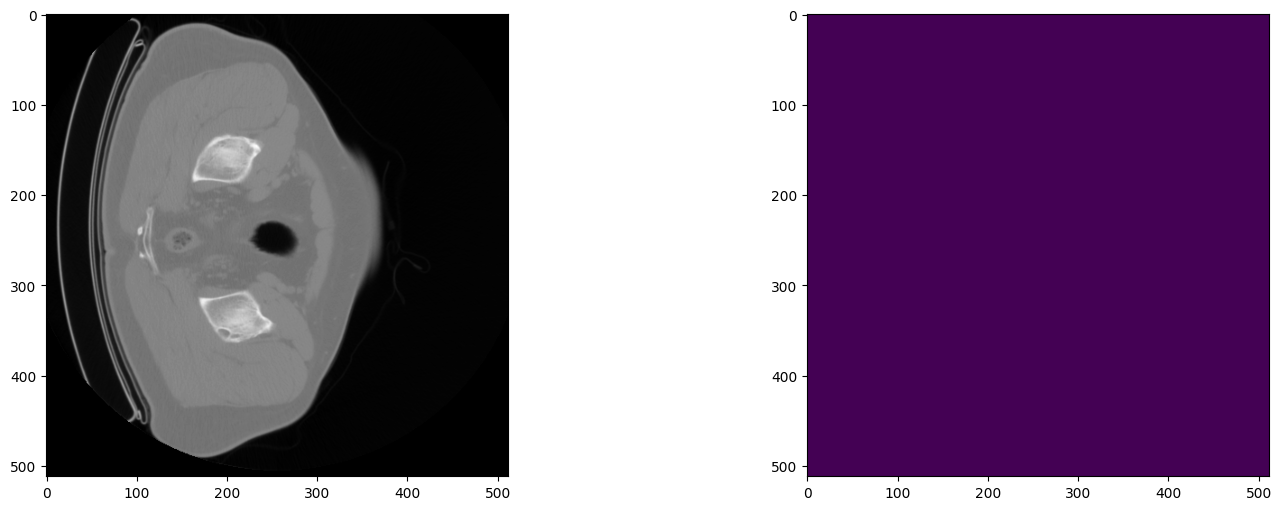

2024-04-21 02:46:38,088 INFO image_writer.py:197 - writing: out/spleen_37/spleen_37_seg.nii.gz
torch.Size([512, 512, 129])


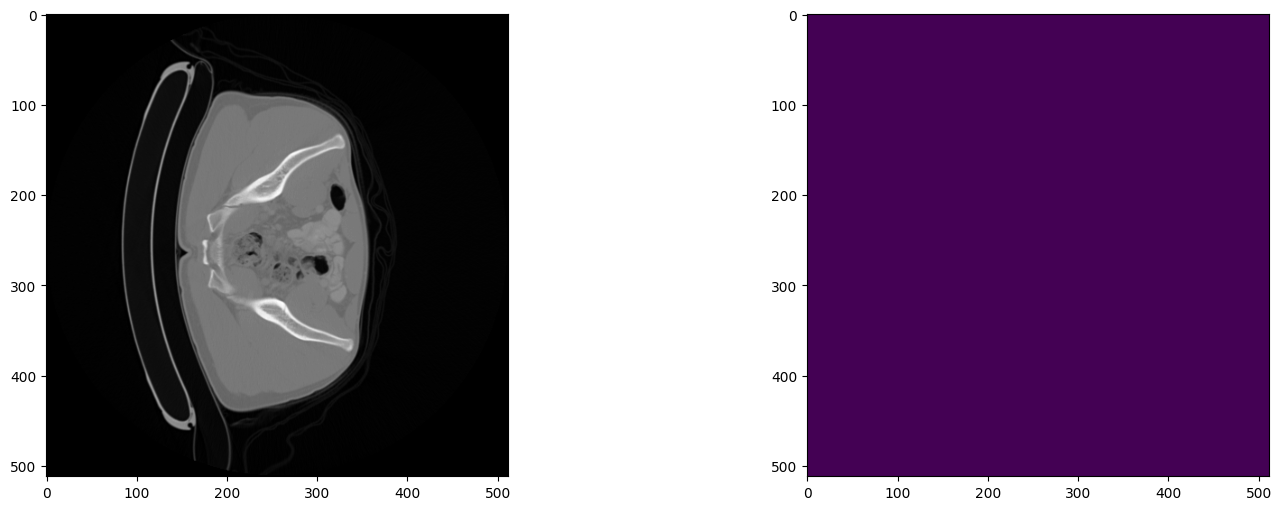

2024-04-21 02:46:42,991 INFO image_writer.py:197 - writing: out/spleen_39/spleen_39_seg.nii.gz
torch.Size([512, 512, 89])


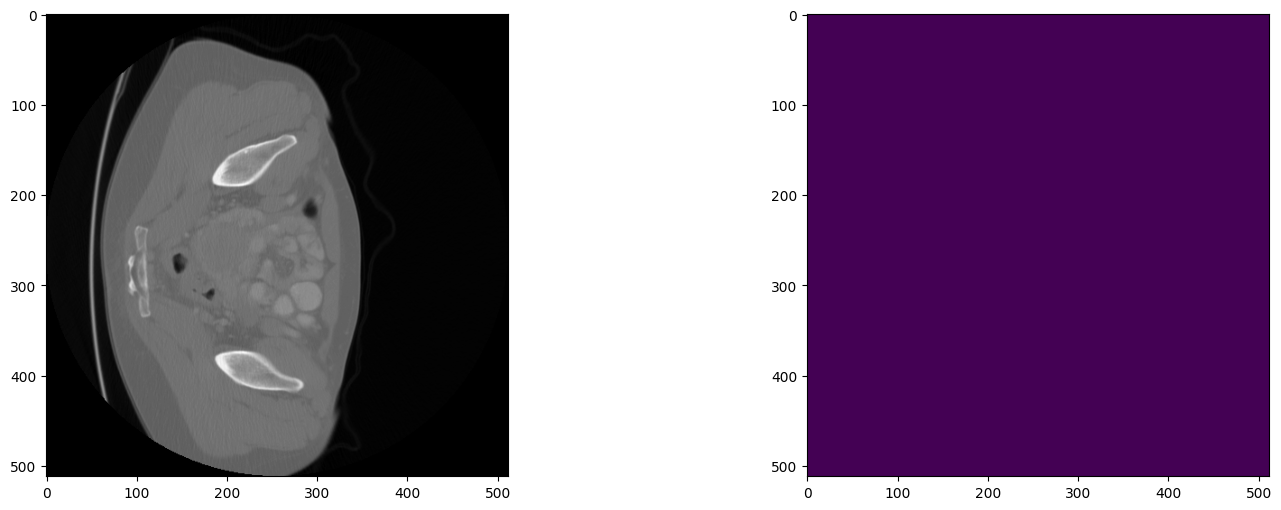

2024-04-21 02:46:46,236 INFO image_writer.py:197 - writing: out/spleen_42/spleen_42_seg.nii.gz
torch.Size([512, 512, 86])


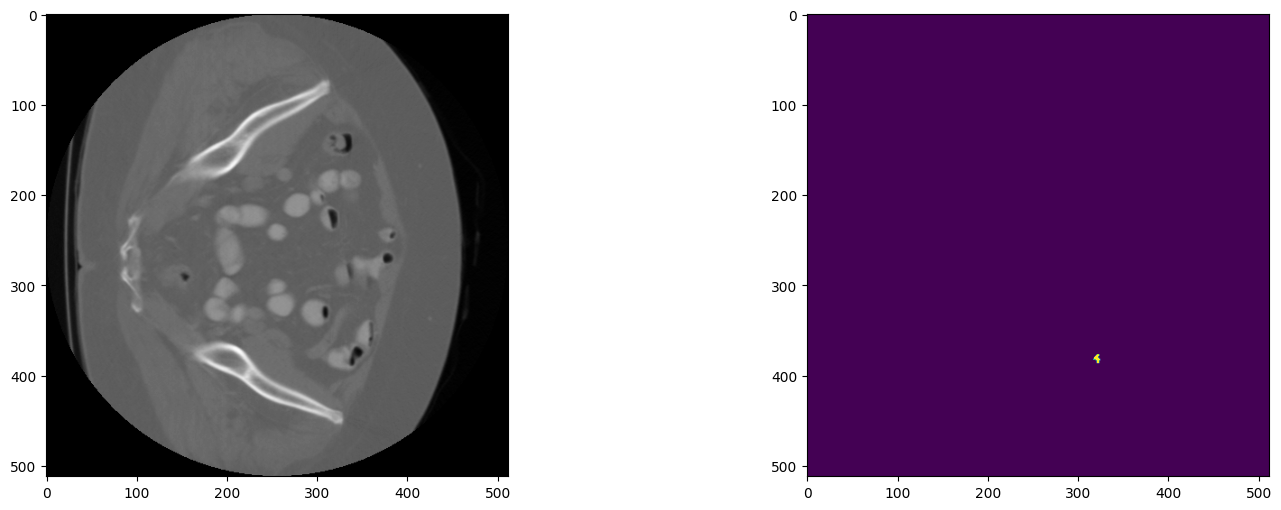

2024-04-21 02:46:49,534 INFO image_writer.py:197 - writing: out/spleen_43/spleen_43_seg.nii.gz
torch.Size([512, 512, 103])


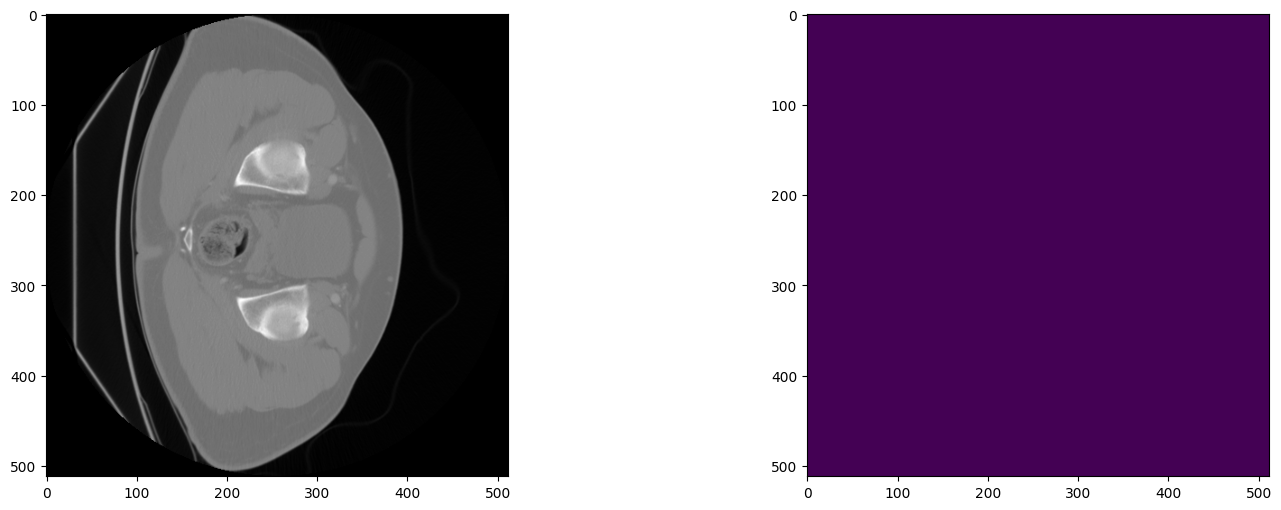

2024-04-21 02:46:53,223 INFO image_writer.py:197 - writing: out/spleen_48/spleen_48_seg.nii.gz
torch.Size([512, 512, 98])


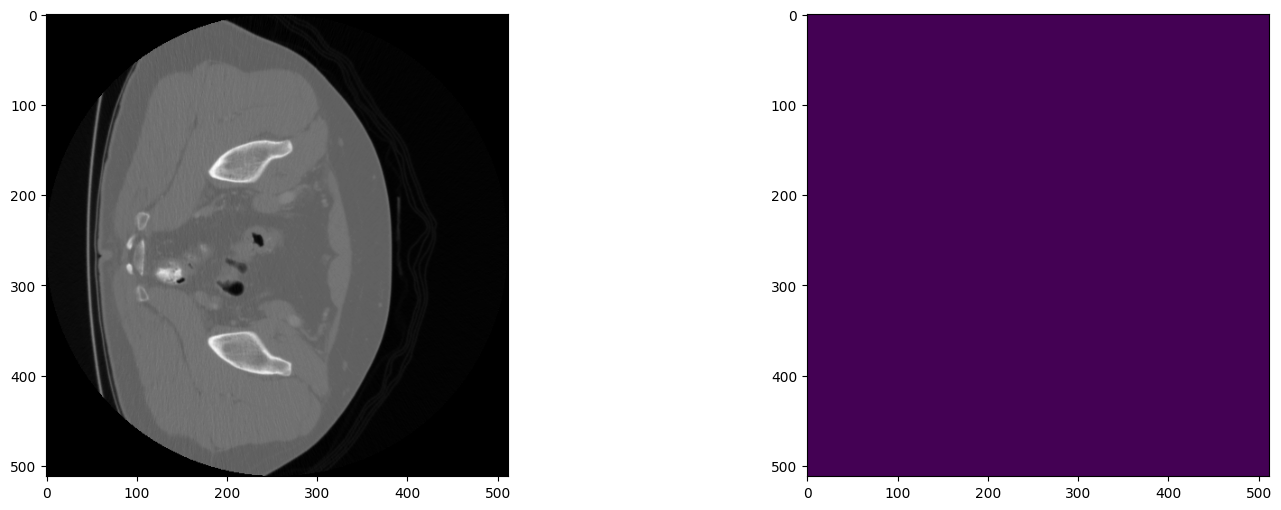

2024-04-21 02:46:56,558 INFO image_writer.py:197 - writing: out/spleen_50/spleen_50_seg.nii.gz
torch.Size([512, 512, 36])


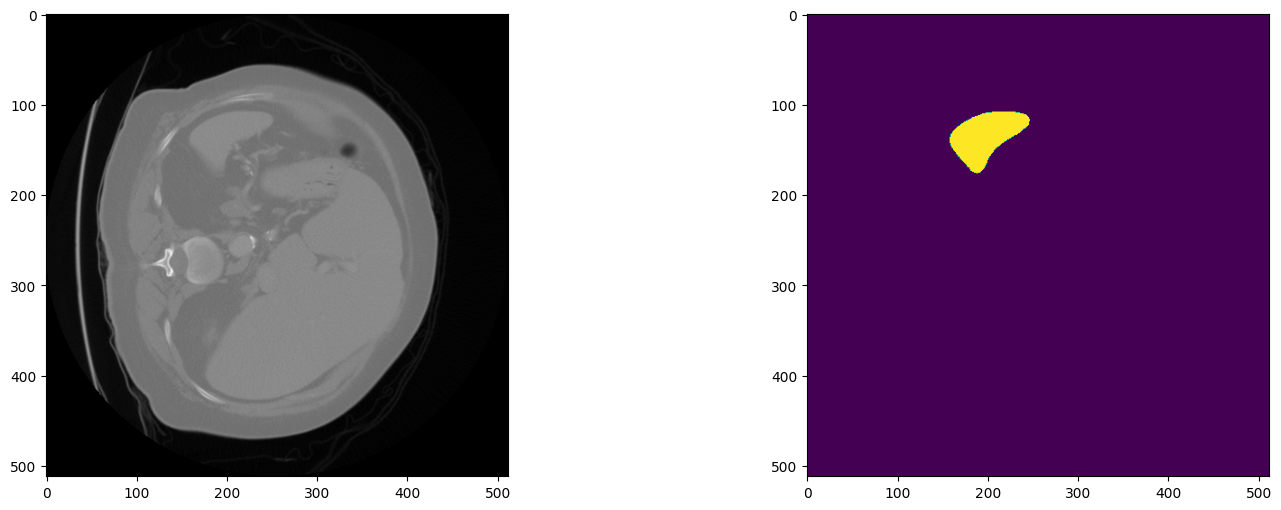

2024-04-21 02:46:58,149 INFO image_writer.py:197 - writing: out/spleen_51/spleen_51_seg.nii.gz
torch.Size([512, 512, 98])


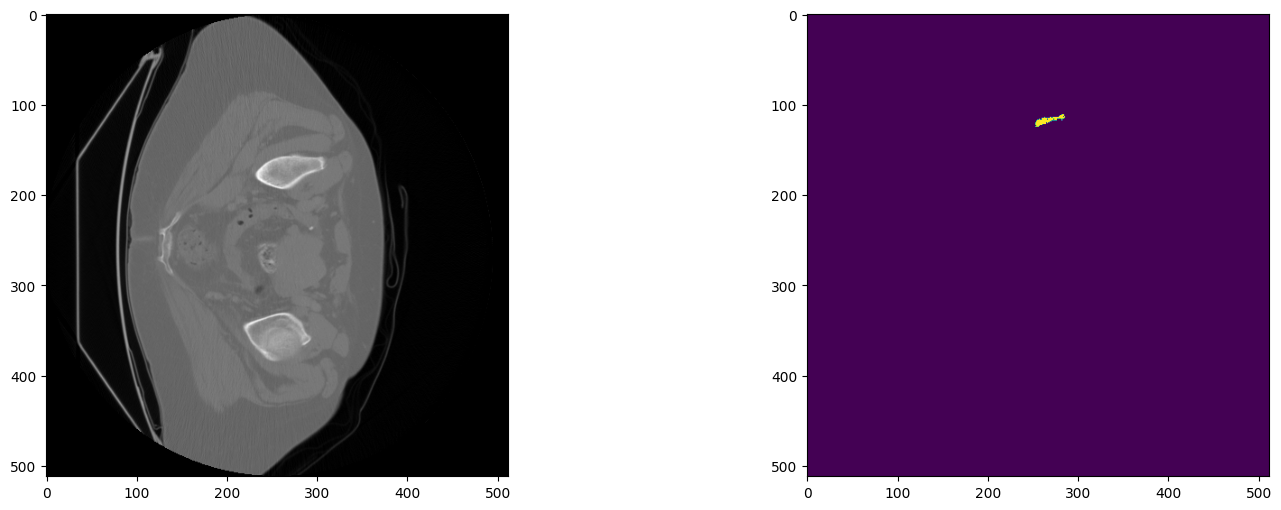

2024-04-21 02:47:01,567 INFO image_writer.py:197 - writing: out/spleen_54/spleen_54_seg.nii.gz
torch.Size([512, 512, 96])


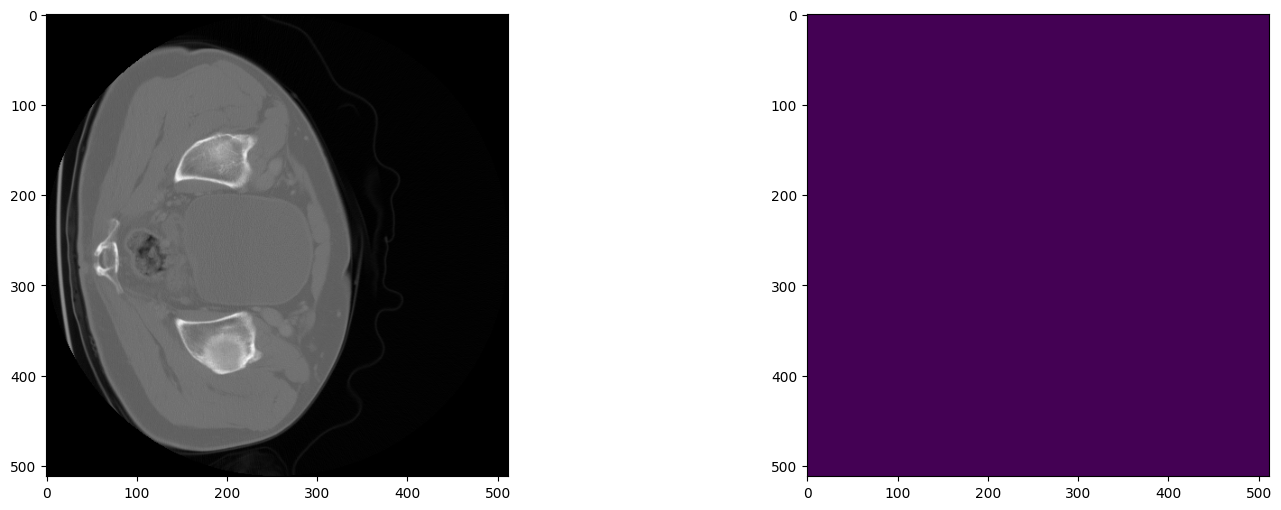

2024-04-21 02:47:04,992 INFO image_writer.py:197 - writing: out/spleen_55/spleen_55_seg.nii.gz
torch.Size([512, 512, 67])


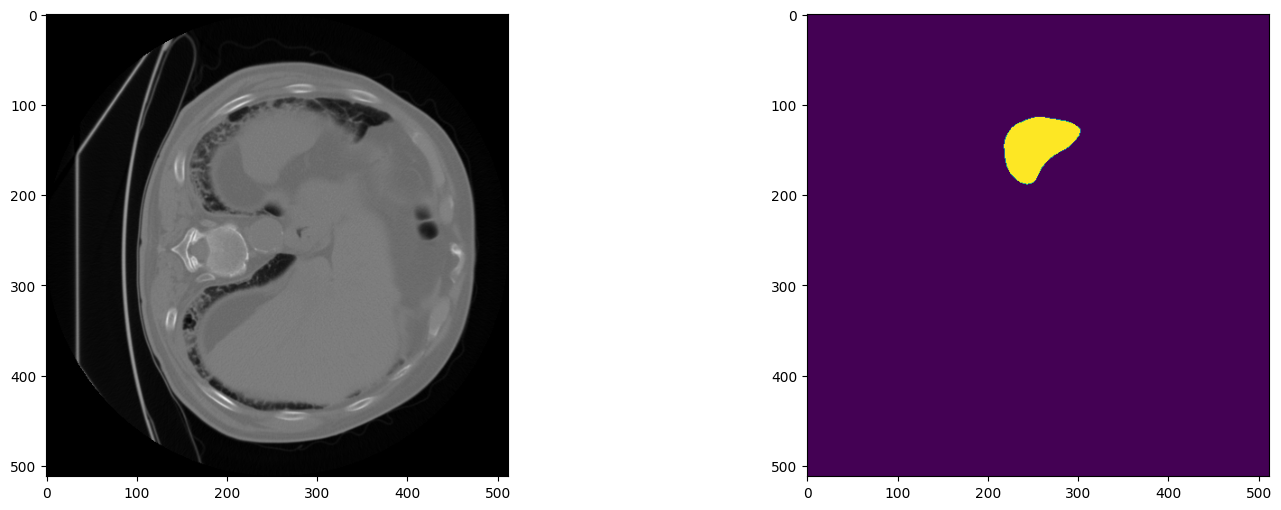

2024-04-21 02:47:07,554 INFO image_writer.py:197 - writing: out/spleen_57/spleen_57_seg.nii.gz
torch.Size([512, 512, 48])


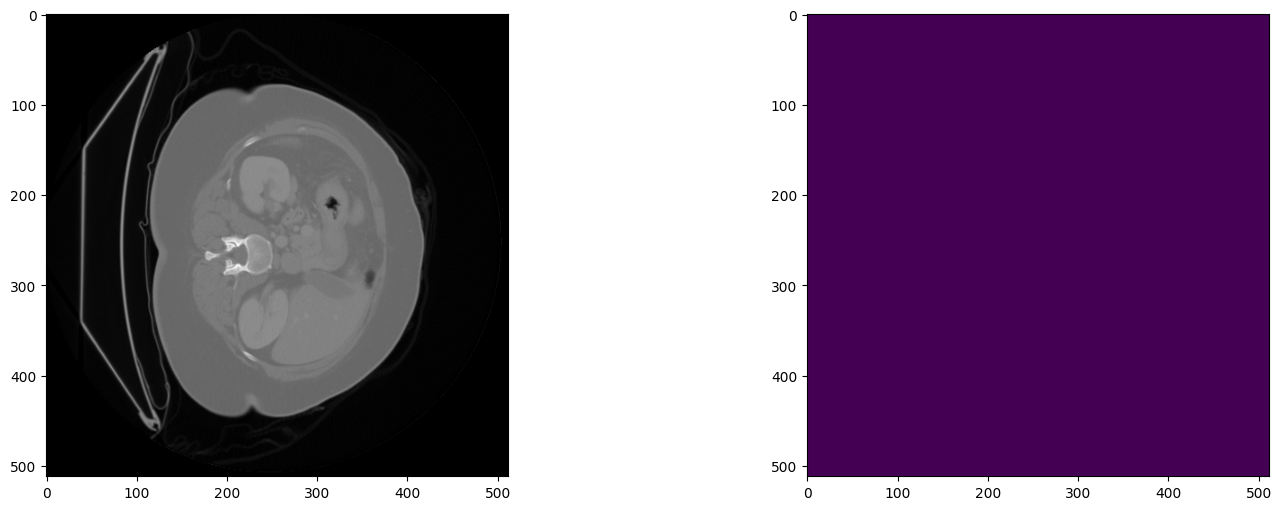

2024-04-21 02:47:09,380 INFO image_writer.py:197 - writing: out/spleen_58/spleen_58_seg.nii.gz
torch.Size([512, 512, 44])


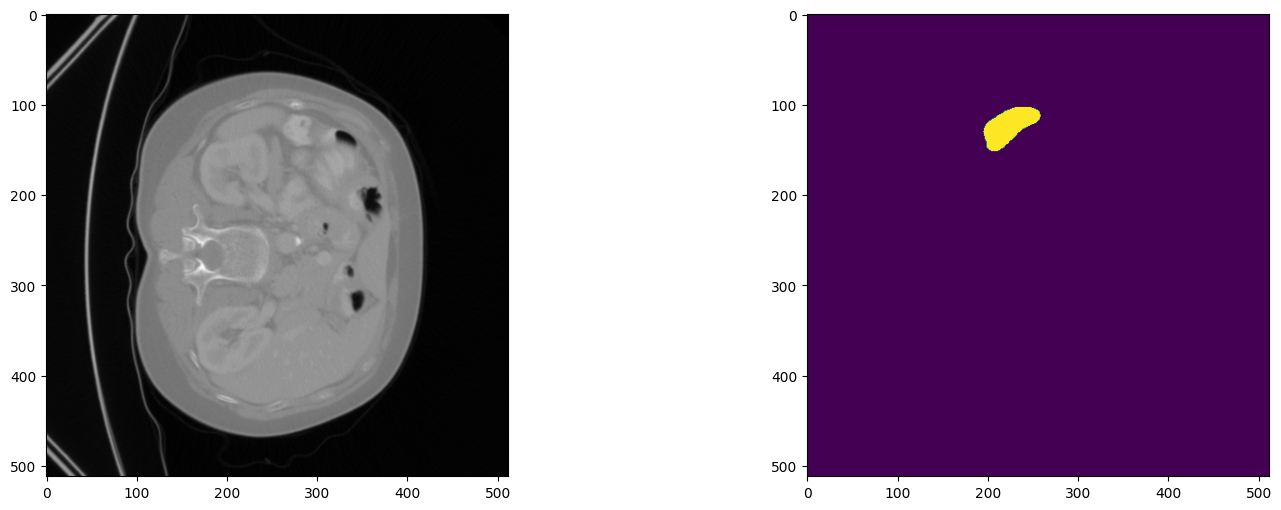

2024-04-21 02:47:11,187 INFO image_writer.py:197 - writing: out/spleen_7/spleen_7_seg.nii.gz
torch.Size([512, 512, 114])


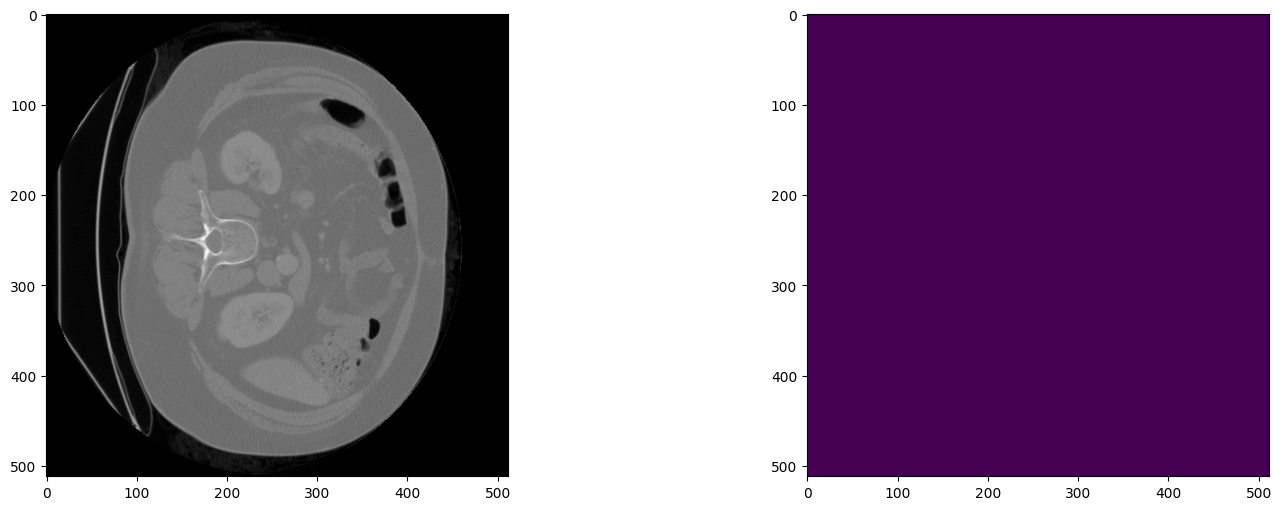

In [18]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])
        print(original_image[0].shape)
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[0][:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()

### Attention-Unet

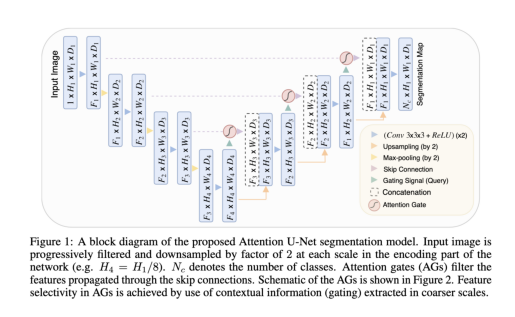

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image_path = "attention_unet.png"


img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [19]:
from monai.networks.nets import AttentionUnet
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = AttentionUnet(spatial_dims=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
        ).cuda()
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [20]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/100
1/16, train_loss: 0.6059
2/16, train_loss: 0.6017
3/16, train_loss: 0.5953
4/16, train_loss: 0.5986
5/16, train_loss: 0.6047
6/16, train_loss: 0.5847
7/16, train_loss: 0.5702
8/16, train_loss: 0.6028
9/16, train_loss: 0.5911
10/16, train_loss: 0.5667
11/16, train_loss: 0.5241
12/16, train_loss: 0.5322
13/16, train_loss: 0.5282
14/16, train_loss: 0.5399
15/16, train_loss: 0.5776
16/16, train_loss: 0.5272
epoch 1 average loss: 0.5719
----------
epoch 2/100
1/16, train_loss: 0.5525
2/16, train_loss: 0.5247
3/16, train_loss: 0.4911
4/16, train_loss: 0.5522
5/16, train_loss: 0.5508
6/16, train_loss: 0.5152
7/16, train_loss: 0.5484
8/16, train_loss: 0.5496
9/16, train_loss: 0.5192
10/16, train_loss: 0.5659
11/16, train_loss: 0.5409
12/16, train_loss: 0.5345
13/16, train_loss: 0.5809
14/16, train_loss: 0.5730
15/16, train_loss: 0.5525
16/16, train_loss: 0.5298
epoch 2 average loss: 0.5426
saved new best metric model
current epoch: 2 current mean dice: 0.0802
best mean d

In [21]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6874 at epoch: 78
